# Enhancing Nonprofit Fundraising Strategy with Predictive Analytics

### Data Dictionary

- **id number:**  *[Do NOT use this as a predictor variable in any models.]*

- **region:** Five geographic regions: `ter1`, `ter2`, `ter3`, `ter4`, `ter5`.

- **ownd:** Homeownership status (`1 = homeowner`, `0 = not a homeowner`).

- **kids:** Number of children.

- **inc:** Household income (7 categories).

- **sex:** Gender (`0 = Male`, `1 = Female`).

- **wlth:** Wealth Rating (0–9), where `9` = highest wealth and `0` = lowest.  
  *Wealth rating uses median family income and population statistics from each area to index relative wealth within each state.*

 - **hv:** Average Home Value in potential donor's neighborhood in $ thousands 

- **incmed:** Median family income in potential donor's neighborhood (in $ thousands).

- **incavg:** Average family income in potential donor's neighborhood (in $ thousands).

- **low:** Percent categorized as “low income” in potential donor's neighborhood.

- **npro:** Lifetime number of promotions received to date.

- **gifdol:** Dollar amount of lifetime gifts to date.

- **gifl:** Dollar amount of largest gift to date.

- **gifr:** Dollar amount of most recent gift.

- **mdon:** Number of months since last donation.

- **lag:** Number of months between first and second gift.

- **gifa:** Average dollar amount of gifts to date.

- **donr:** Classification response variable (`1 = Donor`, `0 = Non-donor`).

- **damt:** Prediction response variable (Donation Amount in $).

> **Note:**  
> The `donr` and `damt` variables are set to *missing* for the **score data**.

### Datasets
- **Non-Profit Dataset:** Training / Model Development dataset. Use this to train, validate, and test models.
- **Non-Profit Score Dataset:** Scoring / Deployment dataset. Contains the same predictors as training data but no target (`donr`, `damt`).

### Project Objectives

- **A classification model** to predict whether someone will donate (`donr` = 1).
- **A regression model** to predict how much they will donate (`damt`) only for likely donors.
- **Deployment:** Use final trained models to predict donation probabilities (`donr`) and expected gift amounts (`damt`).

## 1. Importing Libraris, Packgaes, and Modules 

In [49]:
# Import libraries for data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import libraries for classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Import libraries for regression models
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# Import libraries for model evaluation
from sklearn.metrics import (roc_auc_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, mean_absolute_error, mean_squared_error)

# Utilities
import warnings
warnings.filterwarnings("ignore")

## 2. Exploratory Data Analysis

**For EDA, Training, Model Building, and Testing by using `nonprofit.xlsx` dataset**

In [50]:
# Load the dataset
nonprofit_df = pd.read_excel('nonprofit.xlsx')

# Display first five rows
nonprofit_df.head()

,ID,region,ownd,kids,inc,sex,wlth,hv,incmed,incavg,low,npro,gifdol,gifl,gifr,mdon,lag,gifa,donr,damt
0,1,ter3,1,1,4,1,8,302,76,82,0,20,81,81,19,17,6,21.05,0,0
1,2,ter3,1,2,4,0,8,262,130,130,1,95,156,16,17,19,3,13.26,1,15
2,5,ter3,1,0,4,1,4,295,39,71,14,85,132,15,10,10,6,12.07,1,17
3,6,ter2,1,1,5,0,9,114,17,25,44,83,131,5,3,13,4,4.12,1,12
4,7,ter5,1,3,4,0,8,145,39,42,10,50,74,6,5,22,3,6.50,0,0


In [51]:
# Check dataset shape and basic info
print("Shape:", nonprofit_df.shape)
print(nonprofit_df.info())

Shape: (6002, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6002 entries, 0 to 6001
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      6002 non-null   int64  
 1   region  6002 non-null   object 
 2   ownd    6002 non-null   int64  
 3   kids    6002 non-null   int64  
 4   inc     6002 non-null   int64  
 5   sex     6002 non-null   int64  
 6   wlth    6002 non-null   int64  
 7   hv      6002 non-null   int64  
 8   incmed  6002 non-null   int64  
 9   incavg  6002 non-null   int64  
 10  low     6002 non-null   int64  
 11  npro    6002 non-null   int64  
 12  gifdol  6002 non-null   int64  
 13  gifl    6002 non-null   int64  
 14  gifr    6002 non-null   int64  
 15  mdon    6002 non-null   int64  
 16  lag     6002 non-null   int64  
 17  gifa    6002 non-null   float64
 18  donr    6002 non-null   int64  
 19  damt    6002 non-null   int64  
dtypes: float64(1), int64(18), object(1)
memory usage: 937.9+

**Analysis:**
##### Categorical (Qualitative) variables: `region`, `sex`, `ownd`, and `inc`

Although `ownd`, `sex`, and `inc` are numeric-coded, they represent categories. They should be dummy-encoded or one-hot encoded before modeling.

##### Numeric (Quantitative) Variables: `wlth`, `incmed`, `incavg`, `low`, `npro`, `gifdol`, `gifl`, `gifr`, `mdon`, `lag`, `gifa`
Here, `wlth` behaves more like a numeric ordinal predictor that it represents a progression of wealth that can be correlated with donation probability (donr) or donation amount (damt)

In [52]:
# Converting features into category data type
categorical_cols = ['region', 'ownd', 'sex', 'inc', 'wlth']
for col in categorical_cols:
    nonprofit_df[col] = nonprofit_df[col].astype('category')
nonprofit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6002 entries, 0 to 6001
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID      6002 non-null   int64   
 1   region  6002 non-null   category
 2   ownd    6002 non-null   category
 3   kids    6002 non-null   int64   
 4   inc     6002 non-null   category
 5   sex     6002 non-null   category
 6   wlth    6002 non-null   category
 7   hv      6002 non-null   int64   
 8   incmed  6002 non-null   int64   
 9   incavg  6002 non-null   int64   
 10  low     6002 non-null   int64   
 11  npro    6002 non-null   int64   
 12  gifdol  6002 non-null   int64   
 13  gifl    6002 non-null   int64   
 14  gifr    6002 non-null   int64   
 15  mdon    6002 non-null   int64   
 16  lag     6002 non-null   int64   
 17  gifa    6002 non-null   float64 
 18  donr    6002 non-null   int64   
 19  damt    6002 non-null   int64   
dtypes: category(5), float64(1), int64(14)
memory usage: 

**Analysis:** `region`, `ownd`, `sex`, `inc`, and `wlth` have been converted into category data type so that the models treat them as proper categorical features and one-hot encoding works correctly later during preprocessing.

In [53]:
# Check for missing values
nonprofit_df.isnull().sum()

ID        0
region    0
ownd      0
kids      0
inc       0
sex       0
wlth      0
hv        0
incmed    0
incavg    0
low       0
npro      0
gifdol    0
gifl      0
gifr      0
mdon      0
lag       0
gifa      0
donr      0
damt      0
dtype: int64

**Analysis:** Dataset contains no missing values.

In [54]:
# Summary statistics for numeric columns
nonprofit_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,6002.0,3978.908197,2301.807612,1.00,1985.25,3945.5,5963.75,8009.00
kids,6002.0,1.583972,1.412455,0.00,0.00,2.0,3.00,5.00
hv,6002.0,183.905365,72.770510,51.00,134.00,170.0,218.00,710.00
incmed,6002.0,43.948850,24.664411,3.00,27.00,38.0,55.00,287.00
incavg,6002.0,56.789404,24.833503,14.00,40.00,52.0,68.00,287.00
low,6002.0,13.885038,13.104649,0.00,4.00,10.0,20.00,87.00
npro,6002.0,61.354382,30.305150,2.00,37.00,59.0,83.00,164.00
gifdol,6002.0,115.799567,86.537977,23.00,65.00,91.0,141.00,1974.00
gifl,6002.0,22.981340,29.396428,3.00,10.00,16.0,25.00,642.00
gifr,6002.0,15.653949,12.424625,1.00,7.00,12.0,20.00,173.00


**Analysis:** Summary statistics show that most numeric variables are right-skewed like gift amounts, and average donation amount is `$7.2` with 50% being donars.

**Target Variable Distribution**

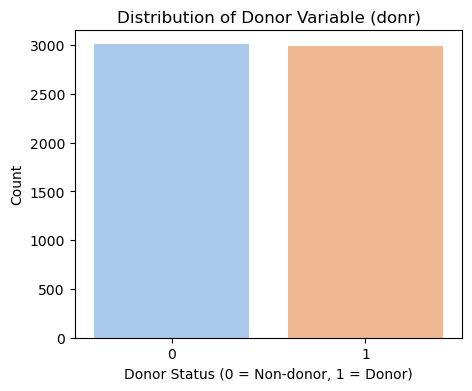

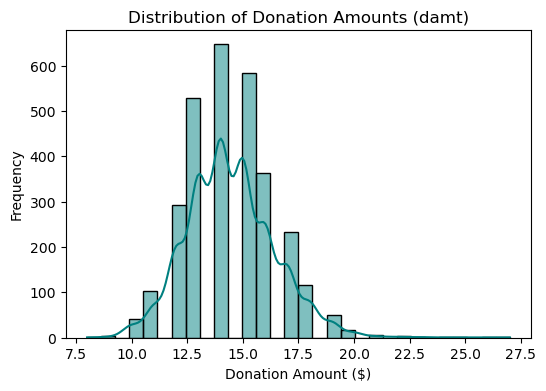

In [55]:
# Distribution of donor variable
donor_counts = nonprofit_df['donr'].value_counts()
plt.figure(figsize=(5,4))
sns.barplot(x=donor_counts.index, y=donor_counts.values, palette='pastel')
plt.title('Distribution of Donor Variable (donr)')
plt.xlabel('Donor Status (0 = Non-donor, 1 = Donor)')
plt.ylabel('Count')
plt.show()

# Distribution of donation amount among donors
plt.figure(figsize=(6,4))
sns.histplot(nonprofit_df.loc[nonprofit_df['donr']==1, 'damt'], bins=30, kde=True, color = 'teal')
plt.title('Distribution of Donation Amounts (damt)')
plt.xlabel('Donation Amount ($)')
plt.ylabel('Frequency')
plt.show()


**Analysis:** Plotd show that donars and non-donars are equally distributed (50%) and donation amounts demsonstrate somewhat bell-shaped distribution with median or mean centered around `$14`, showing mild variation among donars.

**Categorical Variables Exploration**

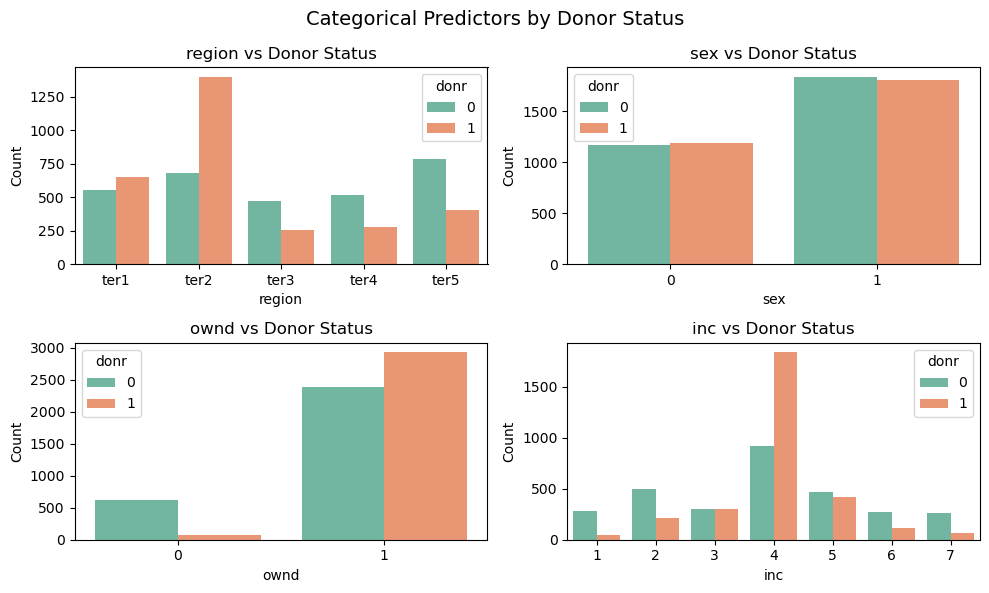

In [56]:
# Visualize distribution of categorical variables by donor status
categorical_vars = ['region', 'sex', 'ownd', 'inc']

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    sns.countplot(data=nonprofit_df, x=var, hue='donr', ax=axes[i], palette='Set2')
    axes[i].set_title(f'{var} vs Donor Status')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
plt.suptitle('Categorical Predictors by Donor Status', fontsize=14)
plt.tight_layout()
plt.show()

**Analysis:** 

These plots enable us to visualize the relationship between donar status and categorical features for detecting any patterns that might helpful to improve model performance and provide direction for feature selection.

Plots illustrate considerable differences across regions, homeownership, and income levels between non-donars and donars, indicating that these features possess predictive value for donar behavior.

**Numeric Variable Distributions**

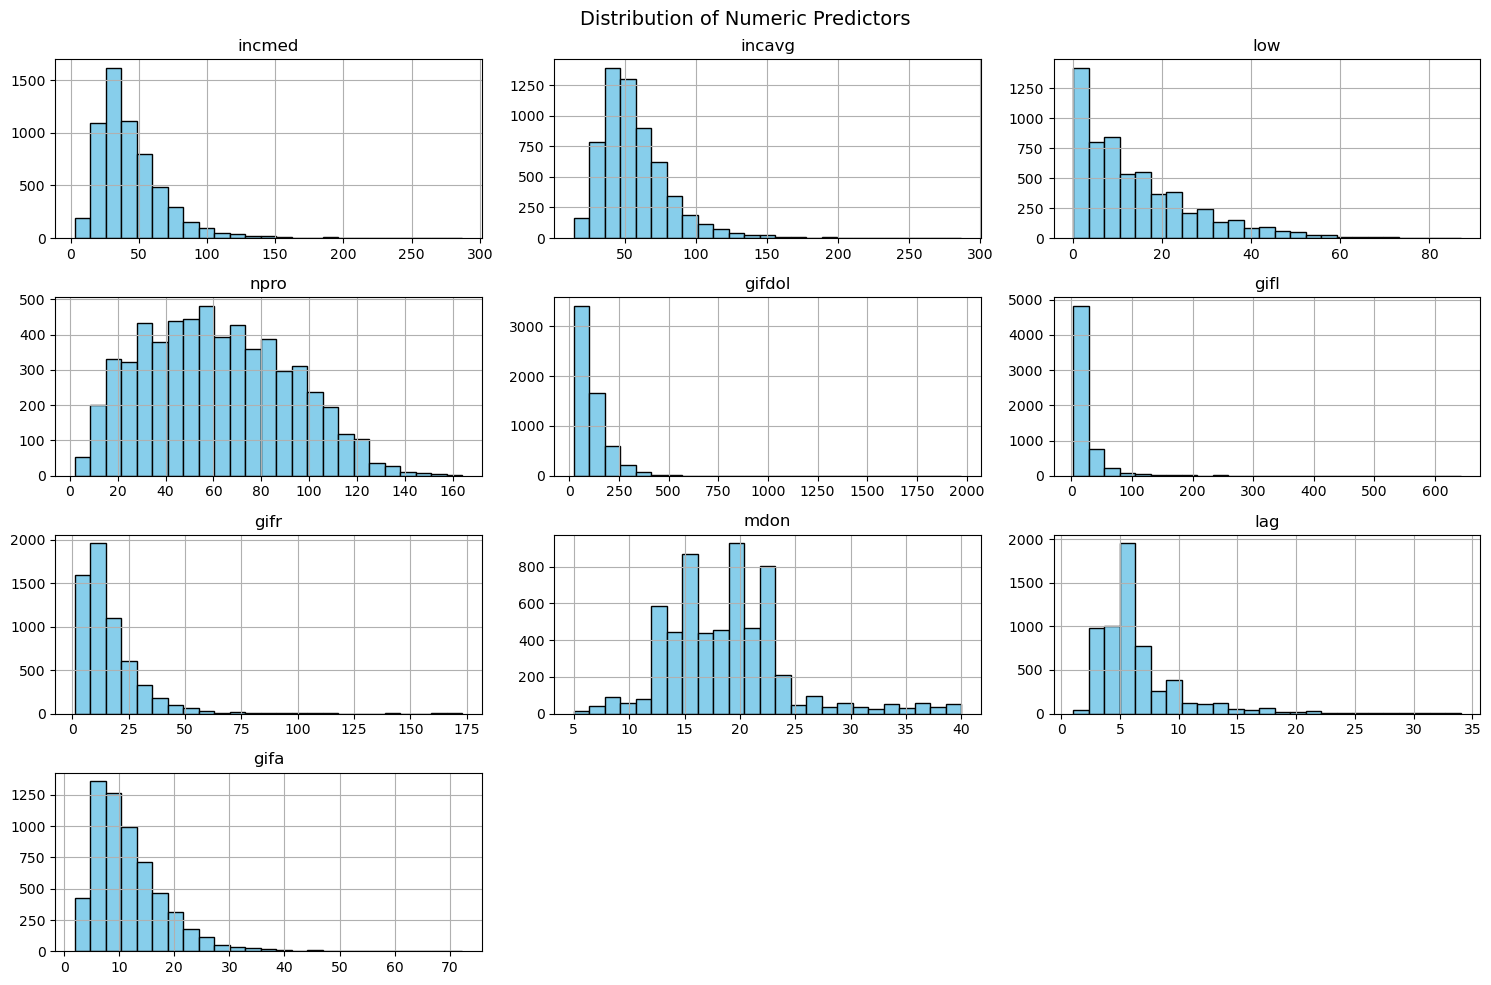

In [57]:
# Plot histograms for all numeric predictor variables
numeric_vars = ['wlth', 'incmed', 'incavg', 'low', 'npro', 
                'gifdol', 'gifl', 'gifr', 'mdon', 'lag', 'gifa']

# Plot histograms
nonprofit_df[numeric_vars].hist(bins=25, figsize=(15,10), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numeric Predictors', fontsize=14)
plt.tight_layout()
plt.show()

**Analysis:**

These distributions provide information about outliers, skewness, and data shape, which is helpful for selecting transformations and enhancing model performance.

Most of the predictors are right-skewed with long tails, indicating the presence of outliers and non-normality, needing for feature scaling.

**Relationship Between Predictors [numeric and categorical] and Donation Status `donr`**

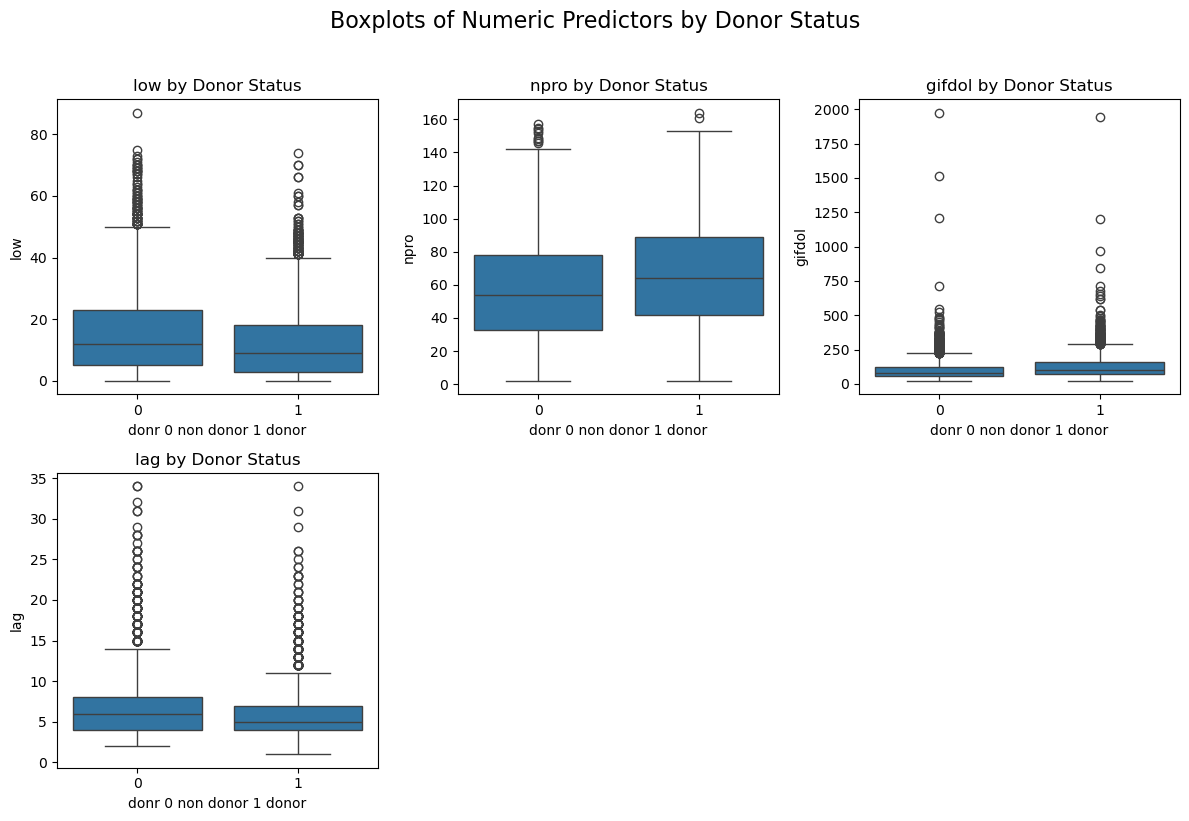

In [58]:
# Creating boxplots of numeric predictors vs donor status (donr)
box_df = nonprofit_df.copy()

# Identify numeric predictors excluding id, targets
drop_cols = {'ID', 'donr', 'damt'}
num_cols = ['low', 'npro', 'gifdol', 'lag']

# Build subplot grid
n = len(num_cols)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows))
axes = np.array(axes).reshape(-1)  # HB17 Flatten for easy indexing

# Plot each numeric feature vs donr
for i, col in enumerate(num_cols):
    sns.boxplot(x='donr', y=col, data=box_df, ax=axes[i])
    axes[i].set_title(f'{col} by Donor Status')
    axes[i].set_xlabel('donr 0 non donor 1 donor')
    axes[i].set_ylabel(col)

# Remove any unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Boxplots of Numeric Predictors by Donor Status', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Analysis:**



**Correlation Analysis**

Potential Multicollinearity check between predictors

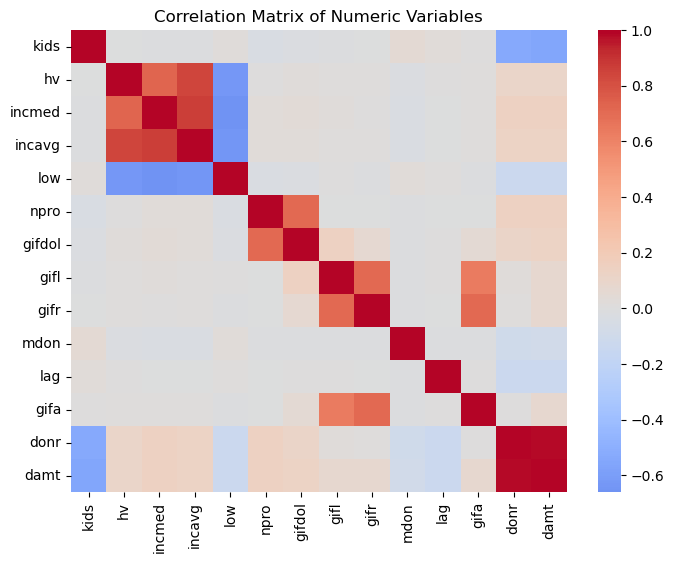

In [59]:
# Correlation analysis among numeric variables
numeric_vars = nonprofit_df.select_dtypes(include=[np.number]).drop(columns=['ID']).columns
corr_matrix = nonprofit_df[numeric_vars].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

**Analysis:**

Correlation matrix helps us to detect redundant predictor variables, multicollinearity, and relationship between features, which is important for feature selection and model enhancement.

This correlation heatmap shows strong positive correlations among income related variables `incmed`, `hv`, `incavg` and gift related variables `gifdol`, `gifa`, `gifl`, and `gifr`. This shows multicollinearity that needs feature reduction for modeling.

**Scatter Plot Analysis:** 

Numeric Predictors vs DOnation Amount `damt`

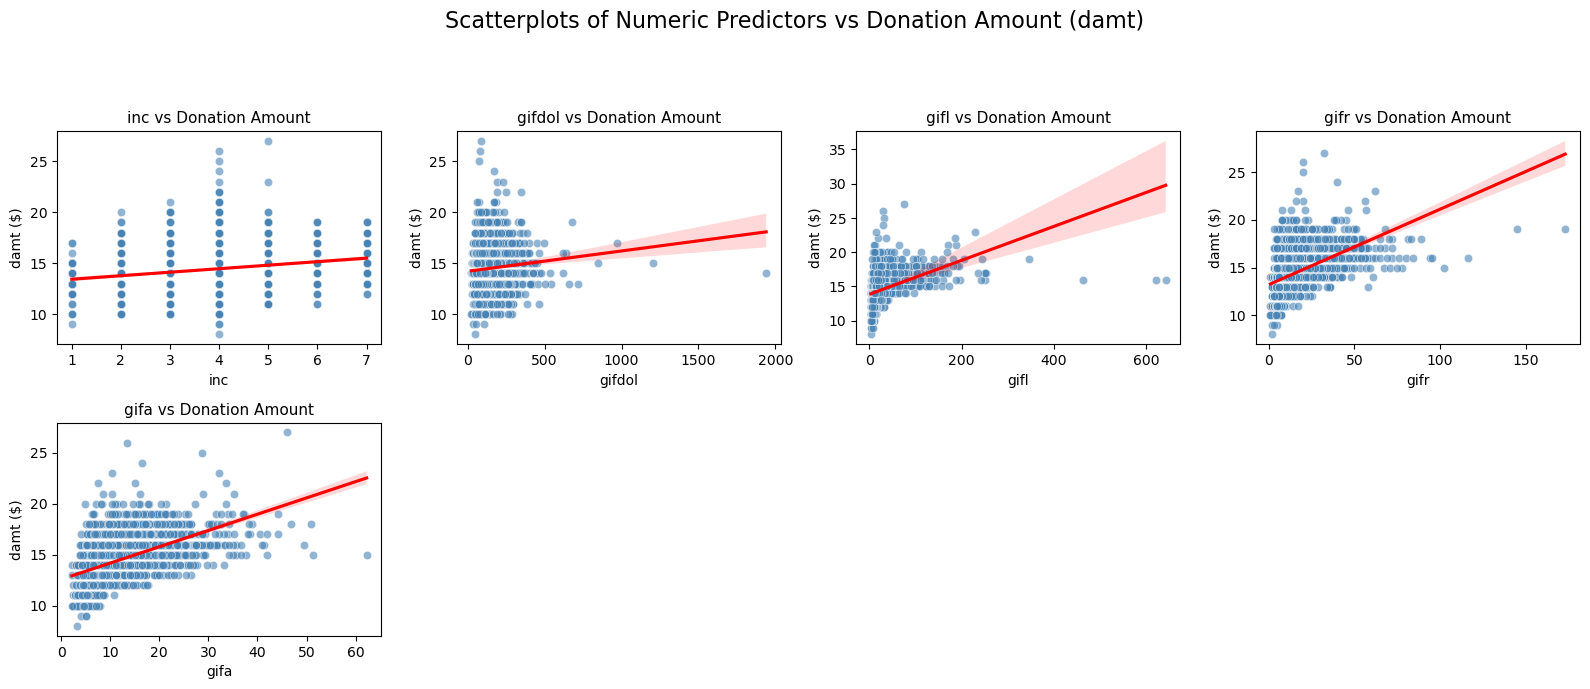

In [60]:
# Creating scatterplots numeric predictors vs donation amount (damt) for donor records
# Filter only donor records
donors_df = nonprofit_df[nonprofit_df['donr'] == 1].copy()

# Define key numeric predictors
donors_df['inc'] = donors_df['inc'].astype(int)
donors_df['wlth'] = donors_df['wlth'].astype(int)

key_vars_damt = ['inc', 'gifdol', 'gifl', 'gifr', 'gifa']

# Create subplot grid
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

# Loop through each predictor and plot scatter + regression line
for i, var in enumerate(key_vars_damt):
    sns.scatterplot(x=var, y='damt', data=donors_df, ax=axes[i], alpha=0.6, color='steelblue')
    sns.regplot(x=var, y='damt', data=donors_df, ax=axes[i], scatter=False, color='red')
    axes[i].set_title(f'{var} vs Donation Amount', fontsize=11)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('damt ($)')

# Remove unused subplots (since 4x3 = 12)
for j in range(len(key_vars_damt), len(axes)):
    fig.delaxes(axes[j])

# Final layout adjustments
plt.suptitle('Scatterplots of Numeric Predictors vs Donation Amount (damt)', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Analysis:**

Trend lines in scatterplots helps us to understand how each predictor relates to the donation amount for linear relationship.

We can see that gift-related variables, `gifl`, `gifr`, and `gifa` have positive relationship with donation amount, indicating they have predictive power.

**Outlier Detection**

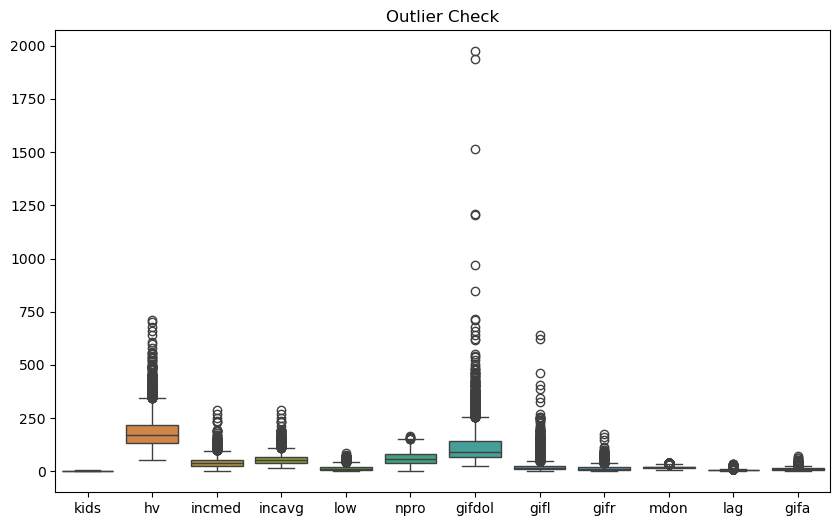

In [61]:
# Check for potential outliers in numeric columns
plt.figure(figsize=(10,6))
sns.boxplot(data=nonprofit_df.drop(columns=['ID','damt', 'donr'], errors='ignore'))
plt.title('Outlier Check')
plt.show()

**Analysis:**

Boxplots have been created to identify extreme outliers because they can distort the scaling and affect model performance.

We can see significant outliers in `gifdol`, `gifl`, `hv`, and `gifr`, indicating a long-tailed distribution, needing for feature scaling. 
These extreme values are not “errors” because they likely represent real high-value donors or wealthy individuals, which are important for modeling and profit estimation. So, we will not remove them.

**Multicollinearity Analysis**

Variance Inflation Factor (VIF) analysis for identifying highly correlated variables to remove redundant information from the model.

In [62]:
# Compute Variance Inflation Factor (VIF) for numeric predictors
from statsmodels.stats.outliers_influence import variance_inflation_factor

col_df = nonprofit_df.copy()

# Use numeric predictors only (drop ID, donr, damt)
X = col_df.select_dtypes(include=[np.number]).drop(columns=['ID', 'donr', 'damt'], errors='ignore')

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))

   Variable        VIF
3    incavg  40.916331
1        hv  24.450670
2    incmed  18.337684
5      npro   9.908092
9      mdon   9.138502
11     gifa   8.728537
8      gifr   6.761424
6    gifdol   5.925085
10      lag   3.757719
7      gifl   3.622076
4       low   2.892684
0      kids   2.225882


**Analysis:**

*For Linear Regression and Logistic Regression only:*

Generally variables with VIF > 10 are removed because those variables are highly correlated with each other. Here, `incavg`, `incmed`, and `hv` measure basically the same thing (Income Neighborhood Varibales). However, we will remove two variables (`incmed` and `hv`) and keep (`incavg`) as it is the  best representative.

Donation History Varibales: Donation history variables (gifa, gifdol, gifr, mdon, npro) are strong predictors. Dropping them would hurt model accuracy. So we will not drop any more variables.

In [63]:
# Use numeric predictors only (drop ID, donr, damt, hv, incmed)
X = col_df.select_dtypes(include=[np.number]).drop(columns=['ID', 'donr', 'damt', 'hv', 'incmed'], errors='ignore')

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))

  Variable       VIF
3     npro  9.877172
7     mdon  8.783897
9     gifa  8.684391
6     gifr  6.755018
1   incavg  6.604841
4   gifdol  5.924220
8      lag  3.723370
5     gifl  3.618811
2      low  2.647629
0     kids  2.216710


**Analysis:** Now, we will not drop any variables as VIF < 10 is acceptable by industry standard thresholds.

## 3. Data Preprocessing

After understanding the structure and relationships, the next step is to clean and prepare the data for modeling.  
Tasks include:
1. Handling missing values  
2. Encoding categorical variables  
3. Scaling numeric features  
4. Splitting data for training and validation

Since we didn't have any missing values in the data, we progressed with the Analysis. Sacling and splitting will be done in modeling part.

### 3.1 Encoding Categorical Variables

Categorical features must be converted into numeric features using `get_dummies()` function for classification models as these models require numeric inputs to make predictions.

In [64]:
# Convert categorical variables  into numeric
nonprofit_df_encoded = pd.get_dummies(nonprofit_df,columns=["region","inc"], drop_first=True)
nonprofit_df_encoded

,ID,ownd,kids,sex,wlth,hv,incmed,incavg,low,npro,...,region_ter2,region_ter3,region_ter4,region_ter5,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7
0,1,1,1,1,8,302,76,82,0,20,...,False,True,False,False,False,False,True,False,False,False
1,2,1,2,0,8,262,130,130,1,95,...,False,True,False,False,False,False,True,False,False,False
2,5,1,0,1,4,295,39,71,14,85,...,False,True,False,False,False,False,True,False,False,False
3,6,1,1,0,9,114,17,25,44,83,...,True,False,False,False,False,False,False,True,False,False
4,7,1,3,0,8,145,39,42,10,50,...,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,8003,1,2,0,8,174,54,69,1,100,...,False,False,False,False,False,False,True,False,False,False
5998,8004,1,1,1,9,227,73,73,0,57,...,True,False,False,False,False,False,False,False,True,False
5999,8005,1,0,1,5,232,33,63,4,54,...,False,False,False,False,False,False,False,False,True,False
6000,8008,1,2,1,1,195,37,44,12,50,...,True,False,False,False,True,False,False,False,False,False


### 3.2 Feature Scaling

Feature scaling is necessary because ML algorithms perform weakly when variables are on differeny scales and also numeric variables contribute equally to the model. 

- Classification Models
  - Scale for: *Logistic Regression, KNN*
  - Do NOT scale for: *Random Forest*
- Prediction Models
  - Scale for: *Linear Regression, KNN Regressor*
  - Do NOT scale for: *Decision Tree Regressor*

We will be scaling features using `Pipeline()` function during modeling.

In [65]:
nonprofit_df_encoded.head()

,ID,ownd,kids,sex,wlth,hv,incmed,incavg,low,npro,...,region_ter2,region_ter3,region_ter4,region_ter5,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7
0,1,1,1,1,8,302,76,82,0,20,...,False,True,False,False,False,False,True,False,False,False
1,2,1,2,0,8,262,130,130,1,95,...,False,True,False,False,False,False,True,False,False,False
2,5,1,0,1,4,295,39,71,14,85,...,False,True,False,False,False,False,True,False,False,False
3,6,1,1,0,9,114,17,25,44,83,...,True,False,False,False,False,False,False,True,False,False
4,7,1,3,0,8,145,39,42,10,50,...,False,False,False,True,False,False,True,False,False,False


## 4. Classification Model
Predict whether a person donates (donr = 1) using variables other than ID and damt.

- LR was selected as it generates well-calibrated probabilities, which can be directly deeded into our expected profit calculation, for donar targeting decisions.
- KNN helps grasp local trends in donation behavior where donars may resemble each other in gift history.
- RF is chosen for handling non-linear relationships and complex interactions in donar bahevior and extarcting feature importance to identify major contributing factors. 

**Three different algorithms**
- Logistic Regression
- K-Nearest Neighbors (KNN)
- Random Forest

In [66]:
nonprofit_df_encoded.columns

Index(['ID', 'ownd', 'kids', 'sex', 'wlth', 'hv', 'incmed', 'incavg', 'low',
       'npro', 'gifdol', 'gifl', 'gifr', 'mdon', 'lag', 'gifa', 'donr', 'damt',
       'region_ter2', 'region_ter3', 'region_ter4', 'region_ter5', 'inc_2',
       'inc_3', 'inc_4', 'inc_5', 'inc_6', 'inc_7'],
      dtype='object')

### 4.1 Split Data into Train and Test set

In [67]:
# For Logistic Regression as we dropped two variables (hv, incmed)
# Define predictors and target for classification
X_logit = nonprofit_df_encoded.drop(columns=['ID', 'damt', 'donr', 'hv', 'incmed', 'sex', 'inc_3', 'gifa', 'gifr', 'gifdol'])
y_logit = nonprofit_df_encoded['donr']

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train_logit, X_valid_logit, y_train_logit, y_valid_logit = train_test_split(X_logit, y_logit, test_size=0.2, random_state=1, stratify=y_logit)
X_train_logit.shape, X_valid_logit.shape

((4801, 18), (1201, 18))

In [68]:
## For KNN and Random Forest
# Define predictors and target for classification
X = nonprofit_df_encoded.drop(columns=['ID', 'damt', 'donr', 'sex', 'inc_3', 'inc_5', 'incavg', 'inc_6', 'gifl', 'gifr', 'inc_2'])
y = nonprofit_df_encoded['donr']

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1, stratify= y)
X_train.shape, X_valid.shape

((4801, 17), (1201, 17))

### 4.2 Logistic Regression

In [69]:
# Logistic Regression baseline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score, roc_curve

logit_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression(C=1.0, solver="liblinear", max_iter=1000))
])
logit_pipe.fit(X_train_logit, y_train_logit)
y_pred_prob_logit = logit_pipe.predict_proba(X_valid_logit)[:,1]
print('Logistic AUC:', roc_auc_score(y_valid_logit, y_pred_prob_logit))

Logistic AUC: 0.9536381233395638


### 4.3 K-Nearest Neighbors

In [70]:
# KNN classification with tuning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', KNeighborsClassifier())
])
param_grid = {'model__n_neighbors': range(3, 25)}
grid_knn = GridSearchCV(knn_pipe, param_grid, cv=5, scoring='roc_auc')
grid_knn.fit(X_train, y_train)
print('Best K:', grid_knn.best_params_)
print('KNN AUC:', roc_auc_score(y_valid, grid_knn.predict_proba(X_valid)[:,1]))

Best K: {'model__n_neighbors': 24}
KNN AUC: 0.9390276707025551


### 4.4 Random Forest

In [71]:
# Random Forest classification
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=50,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_prob_rf = rf.predict_proba(X_valid)[:,1]
print('Random Forest AUC:', roc_auc_score(y_valid, y_pred_prob_rf))

Random Forest AUC: 0.9586936144959206


### 4.5 Comparison and interpretation of the Classification Models

Classification Model Comparison:
                 Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  Logistic Regression    0.8693     0.8519  0.8932    0.8720   0.9536
1       KNN Classifier    0.8601     0.8101  0.9399    0.8702   0.9390
2        Random Forest    0.8809     0.8540  0.9182    0.8850   0.9587


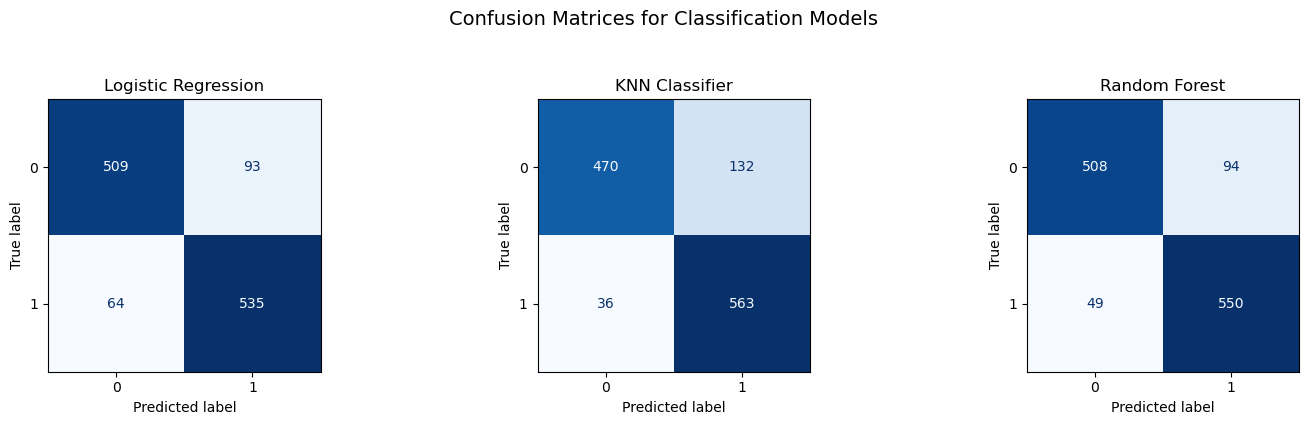

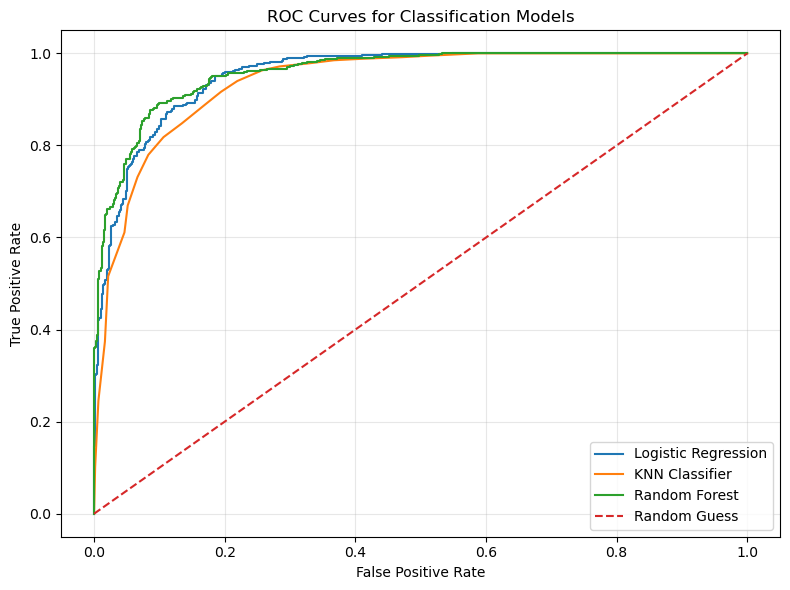

In [72]:
# Compare Logistic, KNN, and Random Forest models on multiple metrics

# Get predicted probabilities for each model
y_prob_logit = logit_pipe.predict_proba(X_valid_logit)[:, 1]  # logistic
y_prob_knn   = grid_knn.predict_proba(X_valid)[:, 1]          # knn
y_prob_rf    = rf.predict_proba(X_valid)[:, 1]                # random forest

# Convert probabilities to class labels (threshold = 0.5)
y_pred_logit = (y_prob_logit >= 0.5).astype(int)
y_pred_knn   = (y_prob_knn   >= 0.5).astype(int)
y_pred_rf    = (y_prob_rf    >= 0.5).astype(int)

# Build metrics table
models = ['Logistic Regression', 'KNN Classifier', 'Random Forest']
y_preds = [y_pred_logit, y_pred_knn, y_pred_rf]
y_probs = [y_prob_logit, y_prob_knn, y_prob_rf]

metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': []}

for name, y_hat, y_hat_prob in zip(models, y_preds, y_probs):
    # Use correct validation target:
    if name == 'Logistic Regression':
        y_true = y_valid_logit
    else:
        y_true = y_valid
    
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(y_true, y_hat))
    metrics['Precision'].append(precision_score(y_true, y_hat, zero_division=0))
    metrics['Recall'].append(recall_score(y_true, y_hat, zero_division=0))
    metrics['F1 Score'].append(f1_score(y_true, y_hat, zero_division=0))
    metrics['ROC AUC'].append(roc_auc_score(y_true, y_hat_prob))

results_df = pd.DataFrame(metrics)
print("Classification Model Comparison:")
print(results_df.round(4))

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, name, y_hat in zip(axes, models, y_preds):
    if name == 'Logistic Regression':
        y_true = y_valid_logit
    else:
        y_true = y_valid
    
    cm = confusion_matrix(y_true, y_hat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(name)

plt.suptitle('Confusion Matrices for Classification Models', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

# ROC Curves
fpr_logit, tpr_logit, _ = roc_curve(y_valid_logit, y_prob_logit)
fpr_knn, tpr_knn, _ = roc_curve(y_valid, y_prob_knn)
fpr_rf, tpr_rf, _ = roc_curve(y_valid, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logit, tpr_logit, label='Logistic Regression')
plt.plot(fpr_knn, tpr_knn, label='KNN Classifier')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classification Models')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### 4.5.1 Feature Importance

This analysis is critical as it discloses the features with most influence on fraud predictions, which later allows decision-makers to interprete and extract solid business insights.

In [73]:
# Extract the logistic regression model from the pipeline
logit_model = logit_pipe.named_steps['model']

# Get feature names AFTER preprocessing (StandardScaler does not change names)
feature_names = X_train_logit.columns

# Get coefficients
coefficients = logit_model.coef_[0]

# Create a DataFrame of feature importance
logit_feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Importance': np.abs(coefficients)})

# Sort by absolute magnitude of coefficients
logit_feat_imp = logit_feat_imp.sort_values(by='Absolute Importance', ascending=False)
logit_feat_imp

,Feature,Coefficient,Absolute Importance
1,kids,-2.301672,2.301672
0,ownd,1.353877,1.353877
14,inc_4,1.148852,1.148852
2,wlth,0.963532,0.963532
9,region_ter2,0.743446,0.743446
5,npro,0.548432,0.548432
8,lag,-0.524379,0.524379
12,region_ter5,-0.520724,0.520724
17,inc_7,-0.486309,0.486309
10,region_ter3,-0.475431,0.475431


In [74]:
# Extract feature importances from RF
importances = rf.feature_importances_

# Create a DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances})

# Sort by importance
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
feat_imp_df

,Feature,Importance
1,kids,0.444548
15,inc_4,0.145904
11,region_ter2,0.090968
0,ownd,0.085547
2,wlth,0.073537
8,mdon,0.029185
7,gifdol,0.025373
9,lag,0.022098
4,incmed,0.017428
6,npro,0.016854


**Feature Importance Analysis:**

From this analysis, we might need to target donars who have children, own their home, live in territory 2 and 5, and belong to higher income categories (4 and7) because these features influence the models for business decision-making. Meanwhile, features with low importance value, such as sex, some income levels can be ignored, which could decrease the cost and enhance target precision. We have removed some features (sex, inc_3, inc_5, incavg, inc_6, gifl, gifr, inc_2). For logistic, features (gifa, gifr, and gifdol) were removed

**All models were run again and changes were made accordingly because models performed well after removing these features**.

#### 4.5.2 Maximum Profitability in Business Using Confusion Matrix

In direct marketing it is not only about accuracy, rather each cell indicates a real financial outcome.

**Business Profit from Each Model**

Profit = (TP x avg_donation) - [(TP + FP) x mailing_cost]

- We only mail to prospects who are predicted as donar (TP) and only TP people donate
- FN and TN don't cost us anything because we do not mail them, so we remove them from calculation
- Avg Donation = `$14.5` and mailing cost = `$2`

So, total profit from three classifier is:
1. Logistics Regression = (535 × 14.5) – ((535 + 93) × 2) = `$6501.5`
2. KNN = (563 × 14.5) – ((563 + 132) × 2) = `$6773.5`
3. Random Forest = (550 × 14.5) – ((550 + 94) × 2) = `$6687`

Profitability analysis was conducted based on confusion matrix, where business costs and benefits were assigned to its outcomes. On the basis of this calculation, the KNN classifier resulted in little higher expected profit (`$6773.5`) than random forest (`$6687`) in business. Therefore, the KNN classifier is the marginally best classification model for this marketing campaign.  

#### 4.5.3 Model Performance Comparison

Our project goal is to maximize the mailing profit and based on profitability analysis above, the KNN looks the best classifier. However, we still need to assess other performance metrices.

1. Accuracy
- RF has the highest accuracy, ≈0.88, while KNN has the lower (≈0.86)
- This means the RF correctly predicts donor vs non-donor more often than the other models.

2. Precision
- RF and LR are the strongest, ≈0.85, while KNN has ≈0.81
- High precision saves money, because each false positive costs `$2`.

3. Recall
- KNN has the best recall, ≈0.93, and RF has almost same ≈0.92
- KNN has the highest recall, but its precision is very low, meaning it mails lots of non-donors. Random Forest provides the best balance of recall and precision.

4. F1 Score
- RF has the highest, ≈0.88, while KNN has lower, ≈0.87
- This shows Random Forest handles both reducing wasted mailings and capturing donors effectively.

5. ROC AUC
- RF has the highest ≈0.96, while KNN has lower ≈0.93
- This means Random Forest does the best job separating donor vs non-donor probability distributions.

Even though KNN mazimizes the profit most, from these performance mertics, we can say that RF is the best model for classification because it has the best probability ranking, highest F1 score, competitive accuracy and precision, and strog recall. On the other hand, KNN has much lower precision, lower F1, lowest probability ranking, and more importantly has highest FP (132), which hurts the profit by increasing mailing cost, because models with more TP and fewer FP maximize the profit. And RF perfectly balances it with second highest TP and almost lowest FP, that is why RF has the highest F1 score. Taling about the Logistics Regression, it is stable, however, it is not the strongest on any metric above. Therefore, for our marketing campaign, `Random Forest` is the best classifier of potential donars.

## 5. Prediction Model
Predict donation amount (damt) among donors only (`donr = 1`).

- MLR is chosen because donation amount shows a roughly linear trend with gift variables, which makes it a good baseline model.
- KNN Regressor captures local similarity in donation amounts, and it is usefule when donars with similar past gift histories tend to donate similar amounts.
- Decsion Tree regressor is selected because it can model non-linears trends in gift amounts.

**Three different algorithms**
 - Multiple Linear Regression
 - KNN Regressor
 - Decision Tree Regressor

### 5.1 Split Data into Train and Test set

Splitting dataset into split and train set is mandatory so the model learns from training set and evaluates on test dataset.

In [75]:
# For Linear Regression Only
# Subset ONLY donors for regression (damt prediction)
donors_df = nonprofit_df_encoded[nonprofit_df_encoded['donr'] == 1]

# Define predictors and target for regression
X_linreg = donors_df.drop(columns=['ID', 'donr', 'damt', 'hv', 'incmed'])
y_linreg = donors_df['damt']

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train_linreg, X_valid_linreg, y_train_linreg, y_valid_linreg = train_test_split(X_linreg, y_linreg, test_size=0.2, random_state=1)
X_train_linreg.shape, X_valid_linreg.shape

((2395, 23), (599, 23))

In [76]:
# Subset ONLY donors for regression (damt prediction)
donors_df = nonprofit_df_encoded[nonprofit_df_encoded['donr'] == 1]

# Define predictors and target for regression
X_don = donors_df.drop(columns=['ID', 'donr', 'damt'])
y_don = donors_df['damt']

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train_d, X_valid_d, y_train_d, y_valid_d = train_test_split(X_don, y_don, test_size=0.2, random_state=1)
X_train_d.shape, X_valid_d.shape

((2395, 25), (599, 25))

### 5.1 Multiple Linear Regression

In [77]:
# Import required libraries
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Ridge regression with hyperparameter tuning
ridge_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', Ridge())])

# Define parameter grid for Ridge alpha
param_grid = {
    'model__alpha': np.logspace(-3, 3, 20)}

# Perform grid search with cross-validation
grid_search = GridSearchCV(ridge_pipe, param_grid, cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1)
grid_search.fit(X_train_linreg, y_train_linreg)

# Get best model and make predictions
best_ridge = grid_search.best_estimator_
pred_ridge = best_ridge.predict(X_valid_linreg)

print('Best Ridge Alpha:', grid_search.best_params_['model__alpha'])
print('Ridge RMSE:', np.sqrt(mean_squared_error(y_valid_linreg, pred_ridge)))
print('Ridge R2:', r2_score(y_valid_linreg, pred_ridge))

# Compare with baseline Linear Regression
lr_reg = Pipeline([
    ('scale', StandardScaler()),
    ('model', LinearRegression())
])
lr_reg.fit(X_train_linreg, y_train_linreg)
pred_lr = lr_reg.predict(X_valid_linreg)
print('\nBaseline Linear RMSE:', np.sqrt(mean_squared_error(y_valid_linreg, pred_lr)))
print('Baseline Linear R2:', r2_score(y_valid_linreg, pred_lr))

Best Ridge Alpha: 1.438449888287663
Ridge RMSE: 1.3737429069804707
Ridge R2: 0.5381757991213265

Baseline Linear RMSE: 1.3737685906459132
Baseline Linear R2: 0.5381585303163867


### 5.2 KNN Regressor

In [78]:
# Import the required libraries for KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn_reg = Pipeline([
    ('scale', StandardScaler()),
    ('model', KNeighborsRegressor())
])
param_grid = {'model__n_neighbors': range(3, 25), 'model__weights': ['uniform', 'distance']}
grid_knn_reg = GridSearchCV(knn_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_knn_reg.fit(X_train_d, y_train_d)
pred_knn = grid_knn_reg.predict(X_valid_d)
print('KNN RMSE:', np.sqrt(mean_squared_error(y_valid_d, pred_knn)))
print('Linear R2:', r2_score(y_valid_d, pred_knn))

KNN RMSE: 1.460484630061009
Linear R2: 0.47801293273155676


### 5.3 Decision Tree Regressor

In [79]:
# Import required libraries
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=7, min_samples_leaf=50, random_state=1)
tree_reg.fit(X_train_d, y_train_d)
pred_tree = tree_reg.predict(X_valid_d)
print('Tree RMSE:', np.sqrt(mean_squared_error(y_valid_d, pred_tree)))
print('Tree R2:', r2_score(y_valid_d, pred_tree))

Tree RMSE: 1.4810648253252543
Tree R2: 0.46319828235069094


### 5.4 Comparison and interpretation of the Prediction Models

In [80]:
# Import required libraries for performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate and display metrics for all regression models
metrics = {'Model': ['Linear Regression', 'KNN Regressor', 'Decision Tree Regressor'],
    
    'RMSE': [
        np.sqrt(mean_squared_error(y_valid_linreg, pred_lr)),
        np.sqrt(mean_squared_error(y_valid_d, pred_knn)),
        np.sqrt(mean_squared_error(y_valid_d, pred_tree))],
    
    'MAE': [
        mean_absolute_error(y_valid_linreg, pred_lr),
        mean_absolute_error(y_valid_d, pred_knn),
        mean_absolute_error(y_valid_d, pred_tree)],
    
    'R2 Score': [
        r2_score(y_valid_linreg, pred_lr),
        r2_score(y_valid_d, pred_knn),
        r2_score(y_valid_d, pred_tree)]}

results_df = pd.DataFrame(metrics)
print(results_df)

                     Model      RMSE       MAE  R2 Score
0        Linear Regression  1.373769  0.946133  0.538159
1            KNN Regressor  1.460485  1.018273  0.478013
2  Decision Tree Regressor  1.481065  1.074318  0.463198


**Model Performance Comparison:** Choosing the best model

Best Regression Model = Lowest RMSE + lowest MAE + highest R²

1. Linear Regression has the lowest **RMSE = 1.3737**
- RMSE measures how much the model’s predictions deviate from the true donation amounts.
- Lower RMSE = better accuracy.
- Linear Regression makes the smallest average prediction errors.*

2. Linear Regression also has the lowest **MAE = 0.9461**
- MAE measures the average absolute error in dollars.
- Lower MAE = more reliable predictions.
- This means Linear Regression is more consistent and produces fewer large mistakes.*

3. Linear Regression has the highest **R² = 0.5381**
- R² shows how much of the variation in donation amounts is explained by the model.
- Higher R² = better explanatory power.
- This means Linear Regression explains about 54 percent of the variation in donation amounts, more than the other models.*

**Final Verdict:**
Based on these metrics, **Linear Regression** is the best DAMT prediction model because:
- It has the lowest RMSE (best accuracy)
- It has the lowest MAE (best reliability)
- It has the highest R² (best explanatory strength)
- It performs smoothly without the instability or overfitting seen in tree models
- It works well for your scaled numerical predictors

*Linear Regression will produce the most stable and accurate estimates of how much donors are likely to give.*

## 6. Model Deployment

**Predict probability of donation and gift amount using best classification and prediction model by using `nonprofit_score.xlsx` dataset**
- Use best classification model to predict the probability of donation (`p_donr`).
- Use best regression model to predict gift amount (`pred_damt`).
- Compute expected profit: $\text{Expected Profit} = (14.5 \times p_{\text{donr}}) - 2$

Then rank by expected profit to decide whom to mail.

We will be using Random Forest for classifying donars (`donr`) and Linear Regression for predicting donation amount ($) (`damt`).

In [81]:
# Load the dataset for deployment
score_df = pd.read_excel('nonprofit_score.xlsx')
score_df

,ID,region,ownd,kids,inc,sex,wlth,hv,incmed,incavg,low,npro,gifdol,gifl,gifr,mdon,lag,gifa,donr
0,3,ter3,1,1,5,1,8,303,61,90,6,64,86,15,10,22,8,17.37,NaN
1,4,ter5,1,1,4,0,8,317,121,121,0,51,56,18,7,14,7,9.59,NaN
2,9,ter3,1,2,3,1,5,194,112,112,0,75,160,28,34,14,4,14.00,NaN
3,16,ter1,0,2,3,1,8,127,24,33,15,39,72,5,4,15,9,5.24,NaN
4,20,ter3,0,2,4,0,3,137,21,40,17,95,186,32,35,23,28,11.70,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,7995,ter2,1,1,5,0,3,94,16,21,55,85,122,8,11,21,5,8.11,NaN
2003,7996,ter1,1,2,4,1,8,223,35,59,10,39,65,14,13,36,3,13.19,NaN
2004,7998,ter3,1,1,4,0,3,91,26,29,28,21,53,43,27,30,5,16.88,NaN
2005,8006,ter2,1,0,2,0,9,163,29,38,15,17,62,8,4,13,7,4.03,NaN


**Data Preparation for Deployment:**

As we did all the cleaning and preprocessing in model training part. Similarly, we need to prepare our `nonprofit_score.xlsx` dataset for model deployment (Category Conversion, One-hot Encoding, and Variables Removal).

In [82]:
# Check dataset shape and basic info
score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2007 non-null   int64  
 1   region  2007 non-null   object 
 2   ownd    2007 non-null   int64  
 3   kids    2007 non-null   int64  
 4   inc     2007 non-null   int64  
 5   sex     2007 non-null   int64  
 6   wlth    2007 non-null   int64  
 7   hv      2007 non-null   int64  
 8   incmed  2007 non-null   int64  
 9   incavg  2007 non-null   int64  
 10  low     2007 non-null   int64  
 11  npro    2007 non-null   int64  
 12  gifdol  2007 non-null   int64  
 13  gifl    2007 non-null   int64  
 14  gifr    2007 non-null   int64  
 15  mdon    2007 non-null   int64  
 16  lag     2007 non-null   int64  
 17  gifa    2007 non-null   float64
 18  donr    0 non-null      float64
dtypes: float64(2), int64(16), object(1)
memory usage: 298.0+ KB


In [83]:
# Converting region into category
cat_cols = ['region', 'ownd', 'sex', 'inc', 'wlth']
for col in cat_cols:
    score_df[col] = score_df[col].astype('category')
score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID      2007 non-null   int64   
 1   region  2007 non-null   category
 2   ownd    2007 non-null   category
 3   kids    2007 non-null   int64   
 4   inc     2007 non-null   category
 5   sex     2007 non-null   category
 6   wlth    2007 non-null   category
 7   hv      2007 non-null   int64   
 8   incmed  2007 non-null   int64   
 9   incavg  2007 non-null   int64   
 10  low     2007 non-null   int64   
 11  npro    2007 non-null   int64   
 12  gifdol  2007 non-null   int64   
 13  gifl    2007 non-null   int64   
 14  gifr    2007 non-null   int64   
 15  mdon    2007 non-null   int64   
 16  lag     2007 non-null   int64   
 17  gifa    2007 non-null   float64 
 18  donr    0 non-null      float64 
dtypes: category(5), float64(2), int64(12)
memory usage: 230.6 KB


In [84]:
# Encode categorical variables in score dataset to match training data
score_df_encoded = pd.get_dummies(score_df, columns=['region', 'inc'], drop_first=True)

# Align columns with training data
X_score = score_df_encoded.drop(columns=['ID', 'damt', 'donr', 'sex', 'inc_3', 'inc_5', 'incavg', 'inc_6', 'gifl', 'gifr', 'inc_2'], errors='ignore')

# Get the columns from training data
train_cols = X.columns

# Add missing columns with 0s and reorder to match training data
for col in train_cols:
    if col not in X_score.columns:
        X_score[col] = 0
        
X_score = X_score[train_cols]
X_score

,ownd,kids,wlth,hv,incmed,low,npro,gifdol,mdon,lag,gifa,region_ter2,region_ter3,region_ter4,region_ter5,inc_4,inc_7
0,1,1,8,303,61,6,64,86,22,8,17.37,False,True,False,False,False,False
1,1,1,8,317,121,0,51,56,14,7,9.59,False,False,False,True,True,False
2,1,2,5,194,112,0,75,160,14,4,14.00,False,True,False,False,False,False
3,0,2,8,127,24,15,39,72,15,9,5.24,False,False,False,False,False,False
4,0,2,3,137,21,17,95,186,23,28,11.70,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,1,1,3,94,16,55,85,122,21,5,8.11,True,False,False,False,False,False
2003,1,2,8,223,35,10,39,65,36,3,13.19,False,False,False,False,True,False
2004,1,1,3,91,26,28,21,53,30,5,16.88,False,True,False,False,True,False
2005,1,0,9,163,29,15,17,62,13,7,4.03,True,False,False,False,False,False


### 6.1 Classification using Random Forest

In [85]:
# 1. Predict donor probability using Random Forest
score_df_encoded['p_donr'] = rf.predict_proba(X_score)[:, 1]

# 2. Extract ID and predicted probability
score_df_encoded[['ID', 'p_donr']]
score_df_encoded

,ID,ownd,kids,sex,wlth,hv,incmed,incavg,low,npro,...,region_ter3,region_ter4,region_ter5,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,p_donr
0,3,1,1,1,8,303,61,90,6,64,...,True,False,False,False,False,False,True,False,False,0.198094
1,4,1,1,0,8,317,121,121,0,51,...,False,False,True,False,False,True,False,False,False,0.560695
2,9,1,2,1,5,194,112,112,0,75,...,True,False,False,False,True,False,False,False,False,0.242064
3,16,0,2,1,8,127,24,33,15,39,...,False,False,False,False,True,False,False,False,False,0.035640
4,20,0,2,0,3,137,21,40,17,95,...,True,False,False,False,False,True,False,False,False,0.134848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,7995,1,1,0,3,94,16,21,55,85,...,False,False,False,False,False,False,True,False,False,0.305837
2003,7996,1,2,1,8,223,35,59,10,39,...,False,False,False,False,False,True,False,False,False,0.339512
2004,7998,1,1,0,3,91,26,29,28,21,...,True,False,False,False,False,True,False,False,False,0.220779
2005,8006,1,0,0,9,163,29,38,15,17,...,False,False,False,True,False,False,False,False,False,0.825531


**Analysis:**

We want to mail only when:
$\text{Expected Profit} = (14.5 \times p_{\text{donr}}) - 2$ > 0

Therefore, we need to solve for p_donr:

p_donr > (2/14.5) = 0.1379

- Therefore, if probability (`p_donr`) > 0.1379, we will send mail to prospects (donor group) 
- Otherwise, when `p_donr` ≤ 0.1379, we will not send mail (non-donor group)

Therefore, the optimal cutoff is **0.1379** for our business. This cutoff ensures that we only mail to individuals whose expected donation exceeds the `$2` mailing cost.

In [86]:
# Threshold for classifying donars and non-donars
threshold = 2 / 14.5   # 0.1379
score_df_encoded['donr'] = (score_df_encoded['p_donr'] > threshold).astype(int)
score_df_encoded[['ID','p_donr','donr']]
score_df_encoded

score_df_encoded[['donr', 'p_donr']].head(10)

,donr,p_donr
0,1,0.198094
1,1,0.560695
2,1,0.242064
3,0,0.035640
4,0,0.134848
5,1,0.762229
6,1,0.541339
7,1,0.168899
8,1,0.307762
9,0,0.069306


### 6.2 Prediction using Linear Regression

In [87]:
# Subset ONLY donors for regression
score_donors = score_df_encoded[score_df_encoded['donr'] == 1].copy()
score_donors

,ID,ownd,kids,sex,wlth,hv,incmed,incavg,low,npro,...,region_ter3,region_ter4,region_ter5,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,p_donr
0,3,1,1,1,8,303,61,90,6,64,...,True,False,False,False,False,False,True,False,False,0.198094
1,4,1,1,0,8,317,121,121,0,51,...,False,False,True,False,False,True,False,False,False,0.560695
2,9,1,2,1,5,194,112,112,0,75,...,True,False,False,False,True,False,False,False,False,0.242064
5,22,1,0,0,9,340,85,117,1,22,...,True,False,False,False,True,False,False,False,False,0.762229
6,23,1,1,1,9,197,64,72,2,56,...,False,True,False,False,False,True,False,False,False,0.541339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,7995,1,1,0,3,94,16,21,55,85,...,False,False,False,False,False,False,True,False,False,0.305837
2003,7996,1,2,1,8,223,35,59,10,39,...,False,False,False,False,False,True,False,False,False,0.339512
2004,7998,1,1,0,3,91,26,29,28,21,...,True,False,False,False,False,True,False,False,False,0.220779
2005,8006,1,0,0,9,163,29,38,15,17,...,False,False,False,True,False,False,False,False,False,0.825531


In [88]:
# Dropping correlated features for linear regression
X_score_linreg = score_donors.drop(columns=['ID', 'donr', 'hv', 'incmed'])
X_score_linreg

,ownd,kids,sex,wlth,incavg,low,npro,gifdol,gifl,gifr,...,region_ter3,region_ter4,region_ter5,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,p_donr
0,1,1,1,8,90,6,64,86,15,10,...,True,False,False,False,False,False,True,False,False,0.198094
1,1,1,0,8,121,0,51,56,18,7,...,False,False,True,False,False,True,False,False,False,0.560695
2,1,2,1,5,112,0,75,160,28,34,...,True,False,False,False,True,False,False,False,False,0.242064
5,1,0,0,9,117,1,22,41,28,25,...,True,False,False,False,True,False,False,False,False,0.762229
6,1,1,1,9,72,2,56,85,15,8,...,False,True,False,False,False,True,False,False,False,0.541339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,1,1,0,3,21,55,85,122,8,11,...,False,False,False,False,False,False,True,False,False,0.305837
2003,1,2,1,8,59,10,39,65,14,13,...,False,False,False,False,False,True,False,False,False,0.339512
2004,1,1,0,3,29,28,21,53,43,27,...,True,False,False,False,False,True,False,False,False,0.220779
2005,1,0,0,9,38,15,17,62,8,4,...,False,False,False,True,False,False,False,False,False,0.825531


In [89]:
# Build feature matrix with SAME columns as used in regression training
reg_cols = X_train_linreg.columns
X_score_linreg = score_donors[reg_cols]
X_score_linreg

,ownd,kids,sex,wlth,incavg,low,npro,gifdol,gifl,gifr,...,region_ter2,region_ter3,region_ter4,region_ter5,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7
0,1,1,1,8,90,6,64,86,15,10,...,False,True,False,False,False,False,False,True,False,False
1,1,1,0,8,121,0,51,56,18,7,...,False,False,False,True,False,False,True,False,False,False
2,1,2,1,5,112,0,75,160,28,34,...,False,True,False,False,False,True,False,False,False,False
5,1,0,0,9,117,1,22,41,28,25,...,False,True,False,False,False,True,False,False,False,False
6,1,1,1,9,72,2,56,85,15,8,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,1,1,0,3,21,55,85,122,8,11,...,True,False,False,False,False,False,False,True,False,False
2003,1,2,1,8,59,10,39,65,14,13,...,False,False,False,False,False,False,True,False,False,False
2004,1,1,0,3,29,28,21,53,43,27,...,False,True,False,False,False,False,True,False,False,False
2005,1,0,0,9,38,15,17,62,8,4,...,True,False,False,False,True,False,False,False,False,False


In [90]:
# Predict donation amount (damt) with linear regression
score_donors['damt_pred'] = lr_reg.predict(X_score_linreg)
score_donors[['ID','damt_pred']]
score_donors

,ID,ownd,kids,sex,wlth,hv,incmed,incavg,low,npro,...,region_ter4,region_ter5,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,p_donr,damt_pred
0,3,1,1,1,8,303,61,90,6,64,...,False,False,False,False,False,True,False,False,0.198094,16.018862
1,4,1,1,0,8,317,121,121,0,51,...,False,True,False,False,True,False,False,False,0.560695,14.005207
2,9,1,2,1,5,194,112,112,0,75,...,False,False,False,True,False,False,False,False,0.242064,15.748858
5,22,1,0,0,9,340,85,117,1,22,...,False,False,False,True,False,False,False,False,0.762229,16.216384
6,23,1,1,1,9,197,64,72,2,56,...,True,False,False,False,True,False,False,False,0.541339,15.700199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,7995,1,1,0,3,94,16,21,55,85,...,False,False,False,False,False,True,False,False,0.305837,14.219642
2003,7996,1,2,1,8,223,35,59,10,39,...,False,False,False,False,True,False,False,False,0.339512,13.686469
2004,7998,1,1,0,3,91,26,29,28,21,...,False,False,False,False,True,False,False,False,0.220779,15.951854
2005,8006,1,0,0,9,163,29,38,15,17,...,False,False,True,False,False,False,False,False,0.825531,12.004001


In [91]:
# Calculate expected profit: (predicted donation amount * probability of donation) - mailing cost
score_donors['expected_profit'] = (score_donors['damt_pred'] * score_donors['p_donr']) - 2

# Sort by expected profit in descending order
score_df_ranked = score_donors.sort_values('expected_profit', ascending=False).reset_index(drop=True)

# Display prospects with profit > 0
score_df_ranked[score_df_ranked['expected_profit']> 0]

,ID,ownd,kids,sex,wlth,hv,incmed,incavg,low,npro,...,region_ter5,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,p_donr,damt_pred,expected_profit
0,6698,1,0,1,9,145,34,36,9,141,...,False,False,False,True,False,False,False,0.952925,18.501347,15.630404
1,2031,1,0,0,8,251,93,93,0,63,...,False,False,False,True,False,False,False,0.940287,17.871268,14.804127
2,6394,1,0,1,7,123,26,39,10,114,...,False,False,False,True,False,False,False,0.929685,17.991893,14.726801
3,7707,1,0,0,9,112,23,38,38,65,...,False,False,False,True,False,False,False,0.887617,18.736619,14.630935
4,3084,1,0,1,6,264,91,91,2,109,...,False,False,False,True,False,False,False,0.937533,17.665165,14.561673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,7711,1,4,1,8,230,46,50,8,75,...,False,False,False,False,True,False,False,0.154747,13.061720,0.021263
1338,5520,1,2,0,9,225,24,72,4,49,...,False,True,False,False,False,False,False,0.142721,14.159714,0.020890
1339,3132,0,2,0,8,127,17,38,29,41,...,False,False,False,True,False,False,False,0.152542,13.243092,0.020129
1340,5416,1,1,1,8,153,23,56,20,61,...,False,False,False,False,False,False,False,0.143105,14.041004,0.009344


**Analysis:** This shows that out of 2007 potential donars, only 1342 potential donars will yeild profit more than 0.

In [92]:
## Saving classifications and Predictions results into a csv file

# Start with the original score_df, not encoded one
final_df = score_df.copy().drop(columns=['donr'], errors='ignore')

# Add predicted probability and donor classification
final_df['Predicted_Donor'] = score_df_encoded['donr']

# Initialize donation amount column with 0 (for non-donors)
final_df['Predicted_Donation_Amount'] = 0

# Fill predicted donation amount ONLY for predicted donors
final_df.loc[score_donors.index, 'Predicted_Donation_Amount'] = score_donors['damt_pred']

# Save everything in one CSV file
final_df.to_csv("nonprofit_score_classifications_and_predictions.csv", index=False)
final_df

,ID,region,ownd,kids,inc,sex,wlth,hv,incmed,incavg,low,npro,gifdol,gifl,gifr,mdon,lag,gifa,Predicted_Donor,Predicted_Donation_Amount
0,3,ter3,1,1,5,1,8,303,61,90,6,64,86,15,10,22,8,17.37,1,16.018862
1,4,ter5,1,1,4,0,8,317,121,121,0,51,56,18,7,14,7,9.59,1,14.005207
2,9,ter3,1,2,3,1,5,194,112,112,0,75,160,28,34,14,4,14.00,1,15.748858
3,16,ter1,0,2,3,1,8,127,24,33,15,39,72,5,4,15,9,5.24,0,0.000000
4,20,ter3,0,2,4,0,3,137,21,40,17,95,186,32,35,23,28,11.70,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,7995,ter2,1,1,5,0,3,94,16,21,55,85,122,8,11,21,5,8.11,1,14.219642
2003,7996,ter1,1,2,4,1,8,223,35,59,10,39,65,14,13,36,3,13.19,1,13.686469
2004,7998,ter3,1,1,4,0,3,91,26,29,28,21,53,43,27,30,5,16.88,1,15.951854
2005,8006,ter2,1,0,2,0,9,163,29,38,15,17,62,8,4,13,7,4.03,1,12.004001


**Saving classifications and Predictions results into a csv file**

In [93]:
# Start with the original score_df, not encoded one
final_df = score_df.copy().drop(columns=['donr'], errors='ignore')

# Add predicted probability and donor classification
final_df['Predicted_Donor'] = score_df_encoded['donr']

# Initialize donation amount column with 0 (for non-donors)
final_df['Predicted_Donation_Amount'] = 0

# Fill predicted donation amount ONLY for predicted donors
final_df.loc[score_donors.index, 'Predicted_Donation_Amount'] = score_donors['damt_pred']

# Save everything in one CSV file
final_df.to_csv("nonprofit_score_predictions.csv", index=False)
final_df

,ID,region,ownd,kids,inc,sex,wlth,hv,incmed,incavg,low,npro,gifdol,gifl,gifr,mdon,lag,gifa,Predicted_Donor,Predicted_Donation_Amount
0,3,ter3,1,1,5,1,8,303,61,90,6,64,86,15,10,22,8,17.37,1,16.018862
1,4,ter5,1,1,4,0,8,317,121,121,0,51,56,18,7,14,7,9.59,1,14.005207
2,9,ter3,1,2,3,1,5,194,112,112,0,75,160,28,34,14,4,14.00,1,15.748858
3,16,ter1,0,2,3,1,8,127,24,33,15,39,72,5,4,15,9,5.24,0,0.000000
4,20,ter3,0,2,4,0,3,137,21,40,17,95,186,32,35,23,28,11.70,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,7995,ter2,1,1,5,0,3,94,16,21,55,85,122,8,11,21,5,8.11,1,14.219642
2003,7996,ter1,1,2,4,1,8,223,35,59,10,39,65,14,13,36,3,13.19,1,13.686469
2004,7998,ter3,1,1,4,0,3,91,26,29,28,21,53,43,27,30,5,16.88,1,15.951854
2005,8006,ter2,1,0,2,0,9,163,29,38,15,17,62,8,4,13,7,4.03,1,12.004001


**Baseline Profit and Model-Based Profit Calculation**

In [94]:
# Baseline Profit
mailing_cost = 2
avg_donation = 14.5
donor_rate = 0.10  # training dataset baseline

baseline_profit_per_person = donor_rate * avg_donation - mailing_cost
baseline_total_profit = 2007 * baseline_profit_per_person
print("Baseline Profit (Mail Everyone):$", baseline_total_profit)

# Model-Based Profit
profitable = score_df_ranked[score_df_ranked['expected_profit'] > 0]
total_profit_model = profitable['expected_profit'].sum()
print("Model-Based Profit (Mail Only Profitable Individuals):$", total_profit_model)

# Profit Improvement
improvement = total_profit_model - baseline_total_profit
print("Profit Improvement Using Model:$", improvement)

Baseline Profit (Mail Everyone):$ -1103.8499999999997
Model-Based Profit (Mail Only Profitable Individuals):$ 5519.282591715389
Profit Improvement Using Model:$ 6623.132591715388


Sending mail to all 2007 individuals would result in a net loss of about `$1,103`, because the baseline donation rate is too low to cover the mailing cost. By targeting only individuals with positive expected profit, the model generates about `$5,519` in profit, which represents a substantial improvement of roughly `$6,623` compared to the baseline strategy.

Total prospects: 1396
Prospects with positive expected profit: 1342
Percentage to mail: 96.13%

Expected profit statistics:
count    1396.000000
mean        3.947621
std         3.386328
min        -0.454774
25%         1.061055
50%         2.971823
75%         6.344766
max        15.630404
Name: expected_profit, dtype: float64


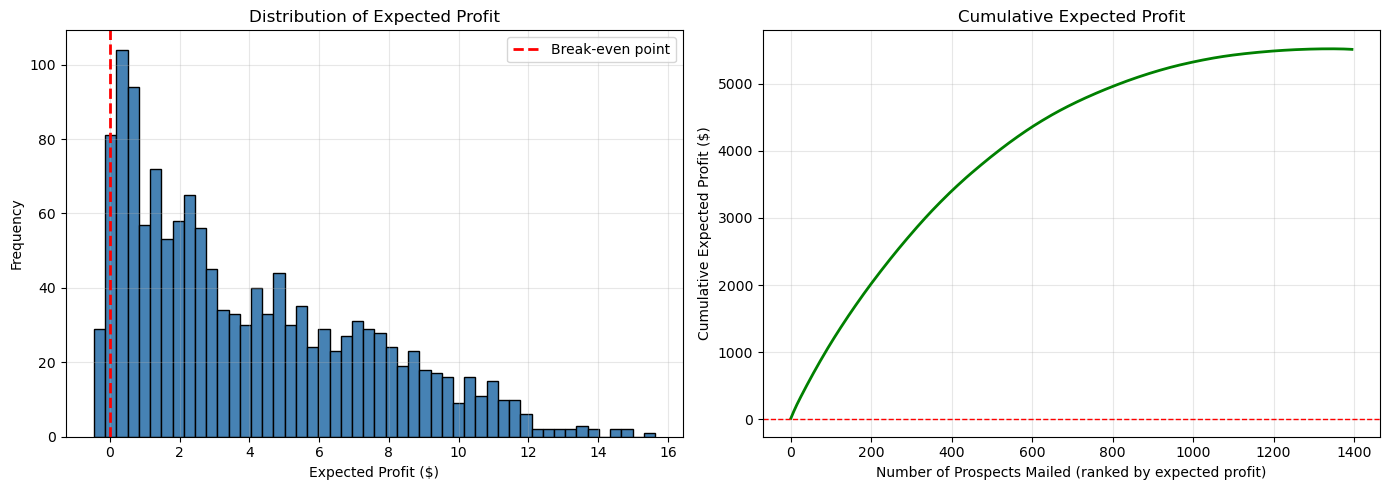

In [95]:
# Summary statistics
positive_profit = score_df_ranked[score_df_ranked['expected_profit'] > 0]
print(f"Total prospects: {len(score_df_ranked)}")
print(f"Prospects with positive expected profit: {len(positive_profit)}")
print(f"Percentage to mail: {len(positive_profit)/len(score_df_ranked)*100:.2f}%")
print(f"\nExpected profit statistics:")
print(score_df_ranked['expected_profit'].describe())

# Visualize expected profit distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of expected profit
axes[0].hist(score_df_ranked['expected_profit'], bins=50, color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even point')
axes[0].set_xlabel('Expected Profit ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Expected Profit')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Cumulative expected profit
score_df_ranked['cumulative_profit'] = score_df_ranked['expected_profit'].cumsum()
axes[1].plot(range(len(score_df_ranked)), score_df_ranked['cumulative_profit'], color='green', linewidth=2)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Number of Prospects Mailed (ranked by expected profit)')
axes[1].set_ylabel('Cumulative Expected Profit ($)')
axes[1].set_title('Cumulative Expected Profit')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Analysis:** Results show that 1457 out of 1515 potentila donars have a expected profit greather than 0, indicating around 96% of mailing list can be targeted for marketing campaigns.Distribution plot shows that most of the predicted donars yield more than `$2` mailing cost. Additionally, cumulative prpfit curve increases quickly for high-value donars and reaches around `$5600`, highlighting that we can send mails to all predicted donars with positive-profit to maximize the total expected revenue from the campaign.

In [96]:
# Create final mailing list recommendation
print("NONPROFIT DIRECT MARKETING CAMPAIGN INSIGHTS:")
print(f"\nTotal prospects in score dataset: {len(score_df_ranked)}")
print(f"Prospects with positive expected profit: {len(positive_profit)}")
print(f"Percentage recommended to mail: {len(positive_profit)/len(score_df_ranked)*100:.2f}%")
print(f"\nTotal expected profit from mailing: ${positive_profit['expected_profit'].sum():.2f}")
print(f"Average expected profit per mailing: ${positive_profit['expected_profit'].mean():.2f}")
print(f"\nTop 10 prospects by expected profit:")
print(score_df_ranked[['ID', 'p_donr', 'damt_pred', 'expected_profit']].head(10).to_string(index=False))

# Export mailing list to CSV
mailing_list = score_df_ranked[score_df_ranked['expected_profit'] > 0]
mailing_list.to_csv('Mailing_list_recommendations.csv', index=False)

NONPROFIT DIRECT MARKETING CAMPAIGN INSIGHTS:

Total prospects in score dataset: 1396
Prospects with positive expected profit: 1342
Percentage recommended to mail: 96.13%

Total expected profit from mailing: $5519.28
Average expected profit per mailing: $4.11

Top 10 prospects by expected profit:
  ID   p_donr  damt_pred  expected_profit
6698 0.952925  18.501347        15.630404
2031 0.940287  17.871268        14.804127
6394 0.929685  17.991893        14.726801
7707 0.887617  18.736619        14.630935
3084 0.937533  17.665165        14.561673
6514 0.845342  18.715102        13.820658
3891 0.914916  17.232789        13.766558
 275 0.908137  17.135926        13.561763
 471 0.952455  16.302652        13.527547
7339 0.932789  16.582813        13.468266
